**General instructions:** 
- This task is intended to be a general DS assessment. If you have applied for an Operational Research role, please contact your recruiter. 
- Please, explain any step or though that you think may be important to evaluate your task. 
- The expected programming language is **python**

- For the sake of the review, we **strongly prefer** to receive back a jupyter notebook containing all the code, comments and thoughts. This notebook should work from end to end, so we can `restart and run all` or  go through it, cell by cell, if we needed to do so.

# TESCO STORES Dataset

At Tesco, the location of a retail store plays a huge role in its commercial success. Our Stores Team use various data sources to better understand the potential of candidate locations for new stores in the UK. They need data science help in designing a model that can predict the future sales **[normalised_sales]** of a store based on location characteristics. Your task is to examine the provided dataset and answer the questions below.

Dataset files
* `tesco-dataset/train.csv`
* `tesco-dataset/test.csv`

Columns
* `location_id`: id of Tesco property location
* `normalised_sales`: normalised sales value of Tesco store
* `crime_rate`: crime rate in the area (higher means more crime)
* `household_size`: mean household size in the area
* `household_affluency`: mean household affluency in the area (higher means more affluent)
* `public_transport_dist`: index of public transport availability in the area
* `proportion_newbuilds`: proportion of newly built property in the area
* `property_value`: average property value in the area
* `commercial_property`: percentage of commercial properties in the area
* `school_proximity`: average school proximity in the area
* `transport_availability`: availability of different transport
* `new_store`: new Tesco store opened recently
* `proportion_nonretail`: proportion of non-retail commercial properties in the area
* `competitor_density`: density of competitor retailers
* `proportion_flats`: proportion of blocks of flats in the area
* `county`: county code of the area

## Q1
Before diving into the modelling, you are given the dataset and the Stores Team expect you to come back with an analysis of the data and any concerns you may have about it. They would also like to know which other information you think would be useful to collect for future developments.

## Q2
Build a model that can predict store sales based on the provided area features. Please show how you developed the model and report how well your model is performing. ***Constraint:*** Please use Random Forest as the model family to solve this problem. 

## Q3
The dataset contains a test set of potential store locations. Use your developed model to predict the sales value in these areas and explain what recommendations you would give to the Stores Team to use it. Use any tools that may help you to share your findings with product owners and other non-technical decision makers in the team. Complete this task by explaining how you would improve the current results.

-------------

## Masked Dataset

You are given the following small dataset, which has been completely masked for privacy reasons. Please train the best model you can come up with to predict the target variable `y` based on the features `x1` and `x2`. Explain every step you take. 

Assuming that this model will be used for making decisions involving important sums of money, provide any comments that you think you should be giving to the business as a technical expert.

Dataset files
* `masked_dataset/train.csv`

# Marco Esposito's Solution

# Tesco Stores Dataset

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle

In [2]:
PATH_DATA = Path('./data/tesco-dataset/')

In [3]:
data = pd.read_csv(PATH_DATA / 'train.csv')
test = pd.read_csv(PATH_DATA / 'test.csv')

In [4]:
data.shape, test.shape

((320, 16), (13, 15))

## Q1 - Preprocessing

Let's take a look at the data.

In [5]:
data.head()

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county
0,464,17.600541,0.0,18.10,no,NaN,2.926,29.0,2.9084,All transport options,666,20.2,368.74,4.5325,-0.399933,c_40
1,504,0.603556,20.0,3.97,no,14.85,4.520,10.6,2.1398,Average transport options,264,13.0,388.37,1.8150,2.216308,c_80
2,295,0.606810,0.0,6.20,no,7.70,2.981,31.9,3.6715,Many transport options,307,17.4,378.35,2.9125,0.166920,c_53
3,187,0.012385,55.0,2.25,no,1.95,3.453,68.1,7.3073,No transport options,300,15.3,394.72,2.0575,-0.083804,c_65
4,193,0.016182,100.0,1.32,no,3.05,3.816,59.5,8.3248,Average transport options,256,15.1,392.90,0.9875,0.962693,c_97


In [6]:
test.head()

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,county
0,105,0.039968,34.0,6.09,no,4.15,3.590,59.6,5.4917,Many transport options,329,16.1,395.75,2.3750,c_42
1,400,0.587758,20.0,3.97,no,14.85,5.398,8.5,2.2885,Average transport options,264,13.0,386.86,1.4775,c_140
2,338,1.116926,0.0,8.14,no,9.40,2.813,0.0,4.0952,Few transport options,307,NaN,394.54,4.9700,c_55
3,227,1.517409,0.0,19.58,no,12.75,3.066,0.0,1.7573,Average transport options,403,14.7,353.89,1.6075,c_62
4,114,83.093533,0.0,18.10,no,16.45,2.957,0.0,1.8026,All transport options,666,20.2,16.45,5.1550,c_22


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   location_id             320 non-null    int64  
 1   crime_rate              320 non-null    float64
 2   proportion_flats        320 non-null    float64
 3   proportion_nonretail    320 non-null    float64
 4   new_store               320 non-null    object 
 5   commercial_property     291 non-null    float64
 6   household_size          320 non-null    float64
 7   proportion_newbuilds    320 non-null    float64
 8   public_transport_dist   320 non-null    float64
 9   transport_availability  320 non-null    object 
 10  property_value          320 non-null    int64  
 11  school_proximity        257 non-null    float64
 12  competitor_density      320 non-null    float64
 13  household_affluency     320 non-null    float64
 14  normalised_sales        320 non-null    fl

In [8]:
data.describe()

,location_id,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,property_value,school_proximity,competitor_density,household_affluency,normalised_sales
count,320.000000,320.000000,320.000000,320.000000,291.000000,320.000000,320.000000,320.000000,320.000000,257.000000,320.000000,320.000000,320.000000
mean,252.387500,3.596375,10.673438,11.307906,16.868557,3.252803,31.849063,3.718765,408.834375,18.589494,359.657562,3.144008,-0.016967
std,145.600582,7.176342,22.579232,7.032693,73.806051,0.695442,27.845777,1.984765,170.888974,2.075529,86.048632,1.774041,0.978561
min,1.000000,0.007142,0.000000,0.740000,1.750000,0.561000,0.000000,1.137000,188.000000,13.000000,3.500000,0.432500,-1.936974
25%,126.500000,0.087937,0.000000,5.130000,5.450000,2.879750,6.350000,2.138075,277.000000,17.400000,376.722500,1.803750,-0.585250
50%,251.500000,0.289681,0.000000,9.900000,9.400000,3.197500,23.400000,3.095750,330.000000,19.100000,392.205000,2.808750,-0.143759
75%,377.250000,4.063553,12.500000,18.100000,14.050000,3.597250,54.450000,5.116700,666.000000,20.200000,396.352500,4.091875,0.243227
max,506.000000,51.693093,100.000000,27.740000,1009.000000,5.725000,94.000000,10.710300,711.000000,21.200000,396.900000,9.492500,2.968477


The maximum of "commercial_property" is larger than 100. This can't be correct as the feature represents a proportion.

In [9]:
data[data.commercial_property >= 100]

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county
96,90,0.138640,0.0,6.91,no,1009.0,3.069,60.0,5.7209,No transport options,233,17.9,389.39,2.3875,-0.171012,c_48
103,394,0.102864,0.0,2.46,no,123.0,4.155,7.8,2.7006,No transport options,193,NaN,394.12,1.2050,1.649456,c_68
224,283,10.541872,0.0,18.10,no,767.0,3.185,1.3,2.2616,All transport options,666,20.2,396.90,4.5325,-0.944983,c_45


Only three instances have a value of "commercial_property" larger than 100, that is, less than $1\%$. We can get rid of them altogether without compromising the modeling.

In [10]:
data.drop(index=data[data.commercial_property >= 100].index, inplace=True)

In [11]:
data.describe()

,location_id,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,property_value,school_proximity,competitor_density,household_affluency,normalised_sales
count,317.000000,317.000000,317.000000,317.000000,288.000000,317.000000,317.000000,317.000000,317.000000,255.000000,317.000000,317.000000,317.000000
mean,252.356467,3.596393,10.774448,11.328265,10.450521,3.250751,31.932492,3.720258,409.258675,18.585882,359.337571,3.148131,-0.018810
std,145.776931,7.194420,22.662083,7.033702,5.776829,0.696799,27.846906,1.988468,170.368892,2.080779,86.392210,1.776872,0.977283
min,1.000000,0.007142,0.000000,0.740000,1.750000,0.561000,0.000000,1.137000,188.000000,13.000000,3.500000,0.432500,-1.936974
25%,127.000000,0.084784,0.000000,5.130000,5.400000,2.879000,6.400000,2.132900,279.000000,17.400000,376.700000,1.805000,-0.585250
50%,251.000000,0.292839,0.000000,9.900000,9.400000,3.202000,23.500000,3.099200,330.000000,19.100000,392.180000,2.812500,-0.138309
75%,377.000000,4.032608,12.500000,18.100000,13.787500,3.595000,54.400000,5.116700,666.000000,20.200000,396.330000,4.087500,0.243227
max,506.000000,51.693093,100.000000,27.740000,26.050000,5.725000,94.000000,10.710300,711.000000,21.200000,396.900000,9.492500,2.968477


We drop "location_id" and "county" - the former is a unique id and won't give useful information in the modeling, and the latter contains $80$ unique elements, around $1$ for each $4$ entries on average, and will probably not be relevant. We can think of using the "county" feature when we have more instances.

We also get rid of $10$ instances where "normalised_sales" is around $2.97$ (see below for an explanation).

In [12]:
data = data[data.normalised_sales <2.9] #comment this line to keep the original distribution of the target variable
target = data.normalised_sales
train = data.drop(['normalised_sales', 'location_id', 'county'], axis=1)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307 entries, 0 to 319
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   crime_rate              307 non-null    float64
 1   proportion_flats        307 non-null    float64
 2   proportion_nonretail    307 non-null    float64
 3   new_store               307 non-null    object 
 4   commercial_property     278 non-null    float64
 5   household_size          307 non-null    float64
 6   proportion_newbuilds    307 non-null    float64
 7   public_transport_dist   307 non-null    float64
 8   transport_availability  307 non-null    object 
 9   property_value          307 non-null    int64  
 10  school_proximity        249 non-null    float64
 11  competitor_density      307 non-null    float64
 12  household_affluency     307 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 33.6+ KB


A quick look at the distribution of the target

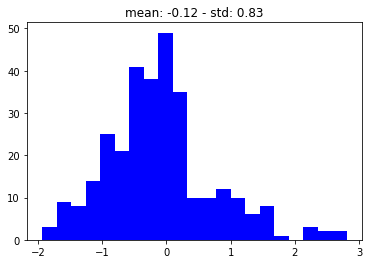

In [14]:
fig, ax = plt.subplots(1, 1)

ax.hist(target, color='blue', bins='auto')
ax.set_title(f'mean: {target.mean():.2f} - std: {target.std(ddof=2):.2f}')
plt.show()

"normalised_sales" represents the difference between the actual sales of a store and the average sales calculated over all stores, rescaled by the standard deviation, hence the negative values. The original distribution of target values has a heavy tail around $3$. If we take a look at it, we notice that it's actually made up of roughly $10$ entries with the same output value, around $2.96$. This suggests that the distribution has been capped at the aforementioned value - in this case, it is better to take out these entries from the training set, as they could affect the performance of the model in a negative way (one can comment the first line 2 cells above to keep the original dataset. This will lead to a poorer performance of the model). It's definitely recommended, however, to consult whomever provided the data to understand something more about these anomalous values - there could be other reasons for their presence in the distribution. 

Let's look at the features' correlation

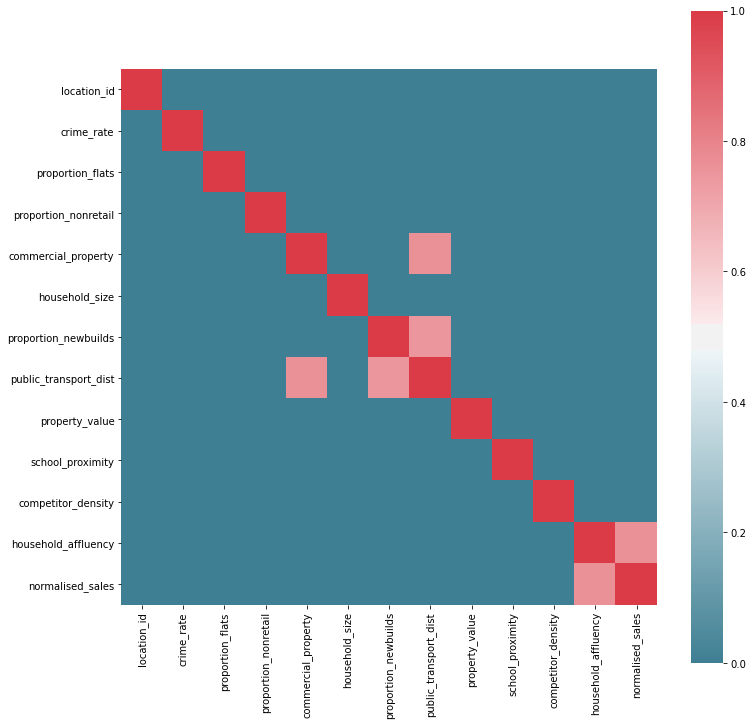

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))
corr = data.corr()
corr = abs(corr)
corr[abs(corr)<0.75] = 0
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
plt.show()

Some features have a correlation above 0.75 - let's take a look at them.

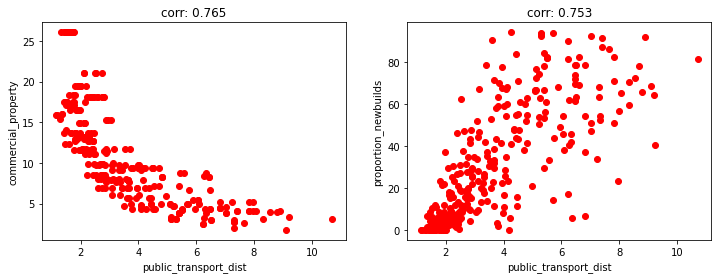

In [16]:
x_ = ['public_transport_dist', 'public_transport_dist']
y_ = ['commercial_property', 'proportion_newbuilds']

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    ax[i].scatter(data[x_[i]], data[y_[i]], color='red')
    ax[i].set_xlabel(x_[i])
    ax[i].set_ylabel(y_[i])
    ax[i].set_title('corr: {:.3f}'.format(corr.loc[x_[i], y_[i]]))

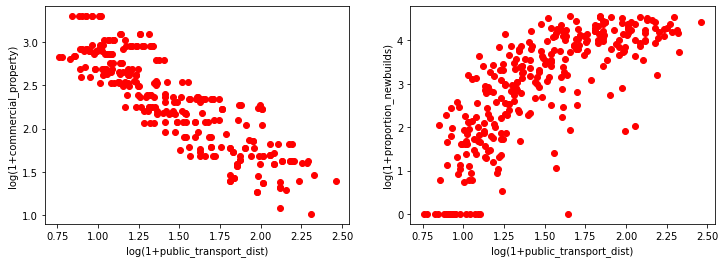

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    ax[i].scatter(np.log1p(data[x_[i]]), np.log1p(data[y_[i]]), color='red')
    ax[i].set_xlabel(f'log(1+{x_[i]})')
    ax[i].set_ylabel(f'log(1+{y_[i]})')
    #ax[i].set_title('corr: {:.3f}'.format(corr.loc[x_[i], y_[i]]))

There is a clear linear dipendence between "commercial_property" ($c$) and "public_transport_dist" ($p$), in a log-log scale. This suggests that $c = Ap^b + D$, where $b<0$. One way to have more robust results out from the modeling is to check how the model performs with and without correlated features. We have not done that here.

There is also one feature that correlates with the target variable. Their scatter plot follows.

Text(0, 0.5, 'normalised_sales')

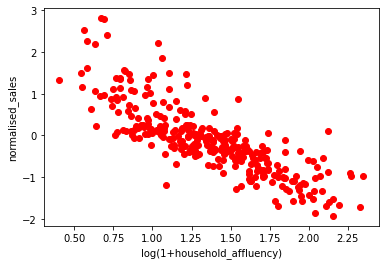

In [18]:
plt.scatter(np.log1p(data.household_affluency), data.normalised_sales, color='red')
plt.xlabel('log(1+household_affluency)')
plt.ylabel('normalised_sales')

In a log-lin scale, there is a linear dipendence between "normalised_sales" and "household_affluency". We can investigate this a bit more.

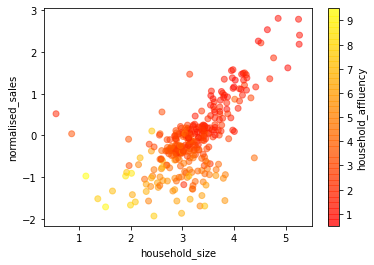

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
color = data.household_affluency
plot1 = ax.scatter(data.household_size, data.normalised_sales, 
                  c=color, cmap='autumn', alpha=0.5)
ax.set_xlabel('household_size')
ax.set_ylabel('normalised_sales')
cbar = plt.colorbar(plot1)
cbar.set_label('household_affluency')

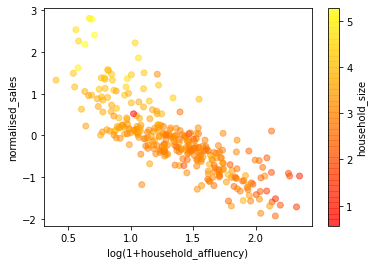

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
color = data.household_size
plot = ax.scatter(np.log1p(data.household_affluency), data.normalised_sales, 
                  c=color, cmap='autumn', alpha=0.5)
ax.set_xlabel('log(1+household_affluency)')
ax.set_ylabel('normalised_sales')
cbar = plt.colorbar(plot)
cbar.set_label('household_size')

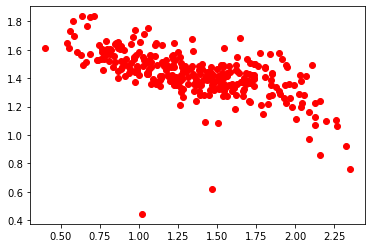

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(np.log1p(data.household_affluency), np.log1p(data.household_size), color='red')

There is a negative correlation between "household_affluency" and both "household_size" and "normalised_sales". There also seems to be a positive correlation between "household_size" and "normalised_sales", suggesting that the more numerous a household, the less affluent it is, and the further from the mean (on the low end) Tesco sales are.

In [22]:
data.transport_availability.unique()

array(['All transport options', 'Average transport options',
       'Many transport options', 'No transport options',
       'Few transport options'], dtype=object)

"transport_availability" can really be seen as a numerical feature, where 'No transport options' represents the lower end of the scale, and 'All transport options' represents the higher end.

In [23]:
train.replace(to_replace=['All transport options', 'Many transport options', 
                         'Average transport options', 'Few transport options', 
                         'No transport options'], value=[4, 3, 2,  1, 0], inplace=True)

There is now only one categorical feature left, "new_store". Let's transform it using one-hot encoding.

In [24]:
train = pd.get_dummies(train)

In [25]:
train.shape

(307, 14)

Let's now look at the distributions of all the numerical features.

/home/marcau/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/home/marcau/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/home/marcau/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/marcau/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


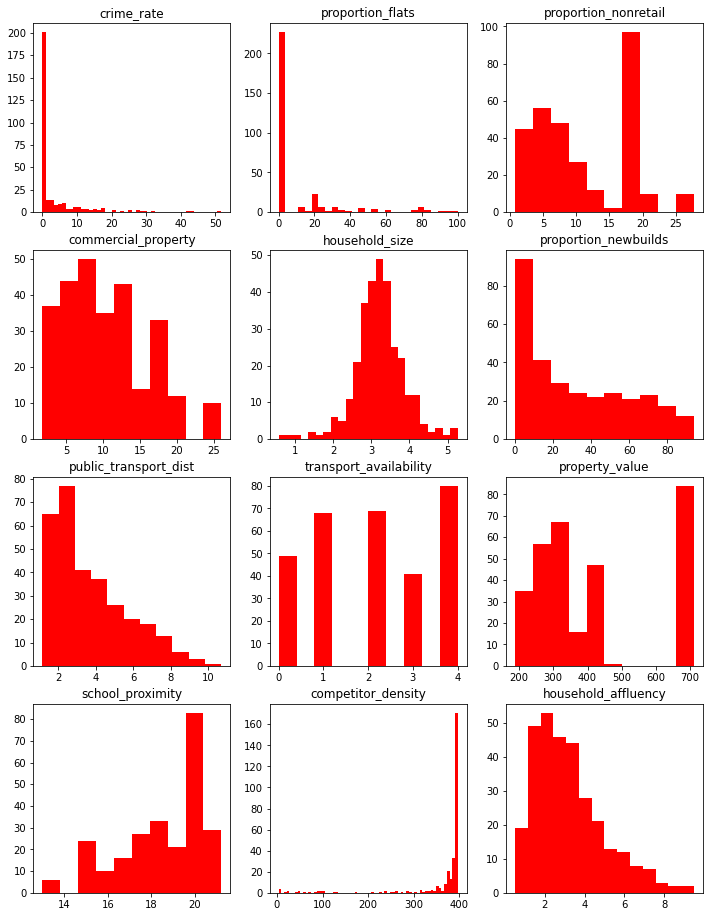

In [26]:
numericalFeatures = train.select_dtypes(exclude=['object'])
nrows, ncols = 4, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 16))

for i in range(nrows):
    for j in range(ncols):
        colNum = i*(ncols)+j
        ax[i,j].hist(numericalFeatures.iloc[:,colNum], bins='auto', color='red')
        ax[i,j].set_title(numericalFeatures.columns[colNum])

plt.show()

Some of these distributions do not look well-behaved and suggest caution. Features like "crime_rate", "property_Value", "school_proximity", "proportion_flats" and "proportion_nonretail" have a large fraction of the values in the same bin (the former around $0$, the latter around $18$). This can be due to a cap of the distribution, or could just be due to the nature of the data (for instance, the proportion of flats could be very close to $0$ in a large number of areas). In addition to discussing these issues with who provided the data, it might be a good idea to check for outliers in these features with algorithms like Isolation Forest or SVM, to get an idea of whether these data are actually healthy. Also, we can think of stratify some features (like the ones that represent a proportion), splitting their values in, i. e., "very low proportion" (between $0\%$ and $25\%$), "low proportion" in $25\%-50\%$ and so on.

In [27]:
train[train['property_value'] > 500]['property_value'].shape,\
train[train['property_value'] > 500]['property_value'].unique()

((84,), array([666, 711]))

The dataset contains $84$ entries where "property_value" is larger than $500$, but there are only two possible values of the feature above this threshold. This suggests, again, capping, or some other issue with the data collection/manipulation.

It is likely that other among the aforementioned features also show this problem.

### To recap

The feature "commercial_property" has $3$ values above $100$, which is impossible for a proportion. It's a good idea to check with the Stores Team whether there is a systematic error during the data collection in order to fix this problem.

In the distribution of the target values there is a number of equal values - other features also exhibit a large number of entries condensed on the same value. This is a possible indicator of an error or data collection/manipulation, i. e., capping of the distribution. Look at this in more detail.

Features representing a proportion ("commercial_property", "proportion_nonretail", "proportion_flats", "commercial_property") can end up having lots of instances with the same few values - it could make sense to bin them.

Lastly, it's a sensible thing to check for outliers in the features, for instance using Isolation Forest or SVM. 

The data we are given can be categorised as:
1. Information about the customers;
2. Information about the area;
3. Business facts.

It would be helpful to know some more about the **stores** themselves. For instance:
1. An index of how large the store is, and how many different items it offers;
2. An index of how the different items are sold by category;
3. An index of how many offers each Store puts out throughout the year.

Also, some more information about **customers**:
1. Mean/median age;
2. How far they travel from their houses to shop at the Tesco store.
Although I reckon that customers' data are more complicated to acquire, as some procedures (surveys, Clubcard, etc.) might introduce bias in the data collection.

## Q2 - Modeling

After some preprocessing we will now turn to the modeling part. First, we need to choose a family of models, and a metric to assess the model against. 

For this task, we will use a Random Forest Regressor (RFR) algorithm, and mean squared error (MSE) as a metric.

Random Forest Regressor is a so-called ensemble learner: this means that uses an ensemble of multiple estimators to get a strong learner. Specifically, it uses several Decision Trees, characterized by high variance, and outputs the average value of the target calculated over the ensemble of Trees - this procedure increases bias.

Since RFs are ensembles of Trees, it is not necessary to scale the data, as it is in many Machine Learning algorithms. The data need to be transformed (if they are categorical - we have used one-hot encoding) and imputed in case some values are missing.

### Missing values

Two features have NaN values and we need to impute them. We can use different strategies: 

1. Remove all the entries where there is at least one missing values;
2. Replace the NaNs with a constant value (usually 0, but it depends on the feature under scrutiny);
3. Replace the NaNs with the mean of the corresponding feature;
4. Replace the NaNs with the median of the corresponding feature;
4. Assume that the missing values are a function of the other features, and use, e. g., k-nearest neighbours to impute them.

The first two options would lead to a substantial loss of information, which is not desirable. We can then try the last three strategies and see which one performs best in the case at hand. 

In [28]:
def nan_imputer(train, strategy):
    
    if (strategy == 'mean'):
        train_imp = train.fillna(train.mean())
    if (strategy == 'median'):
        train_imp = train.fillna(train.median())
    if (strategy == 'function'):
        imputer = KNNImputer()
        train_imp = imputer.fit_transform(train)
        
    return train_imp

We will assess the model against a loss function which is the mean squared error, defined as 

$
L(Y, Y^*; \theta) = \frac{1}{n} \sum_{i=1}^n (y_i(\theta) - y^*_i)^ 2
$

where $Y$ and $Y^*$ represent the vectors of predictions and actual targets, respectively; $n$ is the number of items, and $\theta$ is the vector of the parameters of the model.

In [29]:
strategies = ['mean', 'median', 'function']

model = RandomForestRegressor()

for strategy in strategies:
    train_imp = nan_imputer(train, strategy)
    X_train, X_test, y_train, y_test = train_test_split(train_imp, target, test_size=0.25, random_state=0)
    model.fit(X_train, y_train)
    print(mean_squared_error(y_test, model.predict(X_test)))

0.09589070514150165
0.09932888927571663
0.09082419580176883


It seems that the best strategy for imputation is using the k-nearest neighbours. We can get a more realistic estimate of the error and the standard deviation of the model using cross validation.

In [30]:
print('imputation\nmethod\t\tmean_error\tstd_error') 
for strategy in strategies:
    train_imp = nan_imputer(train, strategy)
    model = RandomForestRegressor()
    cvs = cross_val_score(model, train_imp, target, scoring='neg_mean_squared_error', cv=10)
    print(f'{strategy:10s}\t{-cvs.mean():.4f}\t\t{cvs.std():.4f}')

imputation
method		mean_error	std_error
mean      	0.1047		0.0551
median    	0.1064		0.0595
function  	0.1055		0.0618


The three imputations methods yield a comparable error and standard deviation. Since the knn algorithm is much more computationally expensive, especially on large datasets, we will use the median for the imputation.

### Grid Search

We can now grid search the best parameters using k-fold cross validation.

In [31]:
param_grid = {
             'n_estimators': [20, 50, 100, 200],
             'max_depth': [3, 5, 10, 20, None],
             'min_samples_split': [2, 10, 20], 
             'min_samples_leaf': [1, 5, 10],
              }

Let's make sense of the above parameters:

1. n_estimators: number of estimators (Decision Trees in this case) to average the RFR over; 
2. max_depth: maximum depth of the three. If "None", the nodes are expanded until either all leaves are pure (contain samples with the same target value), or until all leaves contain less then min_samples_split samples (default is 2);
3. min_samples_split: minimum number of samples required to split an internal node;
4. min_samples_leaf: minimum number of samples required to be at a leaf node.

n_estimators is an ensemble parameter, while the others regulate properties of the Trees.

Now let's grid search the best parameters among the ones we provide.

In [32]:
model = RandomForestRegressor()
train_median = train.median()
train_imp = train.fillna(train_median)

gscv = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', 
                   n_jobs=-2, cv=10, verbose=1)

In [33]:
%%time
model = RandomForestRegressor()

gscv.fit(train_imp, target)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 1236 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done 1786 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-2)]: Done 1800 out of 1800 | elapsed:  2.8min finished


CPU times: user 7.33 s, sys: 697 ms, total: 8.03 s
Wall time: 2min 46s


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-2,
             param_grid={'max_depth': [3, 5, 10, 20, None],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [34]:
gscvBestEstimator = gscv.best_estimator_
gscvBestEstimator

RandomForestRegressor(max_depth=20, n_estimators=50)

In [35]:
gscv.best_score_

-0.1062965143968655

The score is $-L$ ($L$ is the cost function), so the estimate of the error is of the order of $0.10$, consistent with the one found with default parameters.

# Q3 - Predictions

## Test Preprocessing

We can now use the model found through grid search to make predictions on the test set. We can also exploit the properties of the RF algorithm to gain an insight into how features affect predictions. 

Firstly, let us do some preprocessing on the test set, i. e. imputation of missing values and one-hot encoding for the categorical values.

In [36]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   location_id             13 non-null     int64  
 1   crime_rate              13 non-null     float64
 2   proportion_flats        13 non-null     float64
 3   proportion_nonretail    13 non-null     float64
 4   new_store               13 non-null     object 
 5   commercial_property     12 non-null     float64
 6   household_size          13 non-null     float64
 7   proportion_newbuilds    13 non-null     float64
 8   public_transport_dist   13 non-null     float64
 9   transport_availability  13 non-null     object 
 10  property_value          13 non-null     int64  
 11  school_proximity        11 non-null     float64
 12  competitor_density      13 non-null     float64
 13  household_affluency     13 non-null     float64
 14  county                  13 non-null     obje

In [37]:
test.fillna(train_median, inplace=True) #impute with the median values of the train set

In [38]:
test.drop(['location_id', 'county'], axis=1, inplace=True)

In [39]:
test.replace(to_replace=['All transport options', 'Many transport options', 
                         'Average transport options', 'Few transport options', 
                         'No transport options'], value=[4, 3, 2,  1, 0], inplace=True)

In [40]:
test = pd.get_dummies(test)

In [41]:
train.describe()

,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,new_store_no,new_store_yes
count,307.000000,307.000000,307.000000,278.000000,307.000000,307.000000,307.000000,307.000000,307.000000,249.000000,307.000000,307.000000,307.000000,307.000000
mean,3.616808,10.522801,11.288176,10.463651,3.211661,32.228990,3.753558,2.114007,409.140065,18.606827,358.577883,3.218412,0.947883,0.052117
std,7.283907,21.989996,7.003502,5.822050,0.644923,27.801917,1.992379,1.424585,169.948387,2.058067,87.668913,1.759289,0.222626,0.222626
min,0.007142,0.000000,0.740000,1.750000,0.561000,0.000000,1.137000,0.000000,188.000000,13.000000,3.500000,0.495000,0.000000,0.000000
25%,0.086886,0.000000,5.130000,5.400000,2.877500,6.650000,2.167650,1.000000,279.500000,17.400000,376.740000,1.881250,1.000000,0.000000
50%,0.282274,0.000000,9.900000,9.400000,3.167000,23.500000,3.102500,2.000000,330.000000,19.100000,392.330000,2.870000,1.000000,0.000000
75%,3.892697,12.500000,18.100000,13.700000,3.547500,54.500000,5.116700,4.000000,666.000000,20.200000,396.900000,4.128750,1.000000,0.000000
max,51.693093,100.000000,27.740000,26.050000,5.266000,94.000000,10.710300,4.000000,711.000000,21.200000,396.900000,9.492500,1.000000,1.000000


In [42]:
test.describe()

,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,new_store_no,new_store_yes
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,8.740234,11.076923,10.938462,10.996154,3.581077,29.915385,3.492546,2.384615,420.230769,17.976923,354.753077,2.755962,0.923077,0.076923
std,22.651266,25.918017,6.326023,5.636321,0.860942,35.797785,1.953115,1.445595,176.230509,2.501051,102.742778,1.599229,0.277350,0.277350
min,0.010238,0.000000,2.970000,2.500000,2.813000,0.000000,1.129600,0.000000,233.000000,13.000000,16.450000,0.617500,0.000000,0.000000
25%,0.159895,0.000000,6.200000,7.150000,3.066000,2.800000,2.065100,2.000000,287.000000,16.100000,383.370000,1.477500,1.000000,0.000000
50%,0.650078,0.000000,8.140000,9.400000,3.297000,10.400000,2.368200,2.000000,329.000000,19.100000,385.960000,2.220000,1.000000,0.000000
75%,5.751892,0.000000,18.100000,15.900000,3.590000,59.600000,5.415900,4.000000,666.000000,20.200000,393.680000,4.317500,1.000000,0.000000
max,83.093533,90.000000,19.580000,19.500000,5.398000,93.400000,7.307300,4.000000,666.000000,20.900000,395.750000,5.155000,1.000000,1.000000


In [43]:
predictions = gscvBestEstimator.predict(test)

In [44]:
predictions

array([ 0.32040568,  2.11144043, -0.81526079,  0.25630778, -1.55107847,
       -0.99207505,  0.15950688,  0.1684457 ,  1.00237241,  0.19809643,
       -0.6055255 ,  2.0828798 , -0.33103825])

In [45]:
testWithPredictions = test.copy()
testWithPredictions['normalised_sales'] = predictions

In [46]:
testWithPredictions

,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,new_store_no,new_store_yes,normalised_sales
0,0.039968,34.0,6.09,4.15,3.590,59.6,5.4917,3,329,16.1,395.75,2.3750,1,0,0.320406
1,0.587758,20.0,3.97,14.85,5.398,8.5,2.2885,2,264,13.0,386.86,1.4775,1,0,2.111440
2,1.116926,0.0,8.14,9.40,2.813,0.0,4.0952,1,307,19.1,394.54,4.9700,1,0,-0.815261
3,1.517409,0.0,19.58,12.75,3.066,0.0,1.7573,2,403,14.7,353.89,1.6075,1,0,0.256308
4,83.093533,0.0,18.10,16.45,2.957,0.0,1.8026,4,666,20.2,16.45,5.1550,1,0,-1.551078
5,10.988323,0.0,18.10,19.50,3.406,2.8,2.0651,4,666,20.2,385.96,4.8800,1,0,-0.992075
6,0.159895,0.0,6.91,4.90,3.169,93.4,5.7209,0,233,17.9,383.37,1.4525,1,0,0.159507
7,9.341992,0.0,18.10,15.90,2.875,10.4,1.1296,4,666,20.2,347.88,2.2200,0,1,0.168446
8,0.010238,90.0,2.97,2.50,4.088,79.2,7.3073,0,285,15.3,394.72,1.9625,1,0,1.002372
9,0.216802,0.0,7.38,7.15,3.431,85.3,5.4159,2,287,19.6,393.68,1.2700,1,0,0.198096


Notice that there is one entry where "crime_rate" is above 80, which is much larger than the maximum observed in the rest of the dataset (around $50$). Also, the same entry has a very low competitor density, a high property value and high affluency - again, an outlier check could be useful.

The Random Forest family provides with a bonus: we can rank the features of the dataset by their "importance", that is, by the effect each of them has in predicting the target value*.

In [47]:
featureImportance = gscvBestEstimator.feature_importances_
featureImportanceNorm = featureImportance/np.max(featureImportance)

featureImportanceDict = {}

for Importance, Feature in zip(featureImportanceNorm, train_imp):
    featureImportanceDict[Feature] = Importance

In [48]:
from operator import itemgetter
featureImportanceDict = dict(sorted(featureImportanceDict.items(), key=itemgetter(1), reverse=True)) 

In [49]:
featureImportanceDict

{'household_affluency': 1.0,
 'household_size': 0.7520782043374913,
 'crime_rate': 0.11229191180041716,
 'public_transport_dist': 0.048662889946826306,
 'property_value': 0.04368055579337426,
 'proportion_newbuilds': 0.04238818306973627,
 'competitor_density': 0.031814023869223655,
 'commercial_property': 0.02692351706121303,
 'school_proximity': 0.025285803063983932,
 'proportion_nonretail': 0.01473489898353313,
 'transport_availability': 0.0074730163311902235,
 'proportion_flats': 0.003635281334763531,
 'new_store_yes': 0.0009423848419772584,
 'new_store_no': 0.0008369770673952741}

From the above we gather that "household_affluency" is the most important features in terms of weight in predicting the target value. Let's make a plot to see how the other feature compare to it.

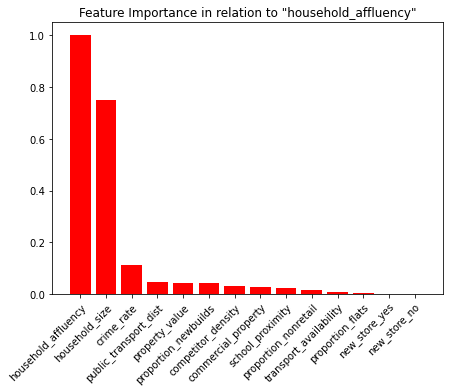

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

xBarChart = np.arange(len(featureImportanceDict))
labelsBarChart = featureImportanceDict.keys()
bar = ax.bar(xBarChart, featureImportanceDict.values(), color='red')

ax.set_xticks(xBarChart)
ax.set_xticklabels(labelsBarChart)

ax.set_title('Feature Importance in relation to "household_affluency"')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.show()

The above plot shows how much each feature is important in predicting the target value compared to the most important one (which is "household_affluency"). A close second is "household_size", which is roughly $84\%$ as important as the 1st one. Third is "crime_rate", further down at $10\%$ importance, and others follow at $\leq 5\%$. 

The plot above can be translated as follows: 

    the quantities that most influence how much a Tesco store in one area sells compared to the average store are the household affluency and the household size. Specifically, areas where households are more affluent and less numerous is correlated with a poor performance of the store.

Lastly, let's look at the distribution of the predicted target values

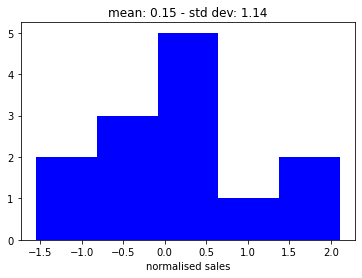

In [51]:
plt.hist(predictions, bins='auto', color='blue')
plt.title(f'mean: {predictions.mean():.2f} - std dev: {predictions.std(ddof=2):.2f}')
plt.xlabel('normalised sales')
plt.show()

The above distribution is not too different from the distribution of targets.

### To recap

After exploring the data, we have made some changes to the original dataset for several reasons (some of the features had anomalous values, we have transformed features to obtain new ones, etc). We have checked for correlation between features (and the target column), and have found that some features exhibited a clear correlation with the target value (household_affluency and household_size). 

After using a Random Forest Regressor to fit these data (and Mean Squared Error as a metric to assess the model against) we find that such features are the most indicative of the performance of a Tesco store in terms of sales.

Some steps can be taken in order to improve on the existing model.

Firstly, thoroughly examine all the features that we have identified as somehow anomalous. This means checking with whomever provided the data to understand if any step could have led to unwanted values in the dataset; or using algorithms to spot outliers (e. g., Isolation Forest or SVM).

Secondly, getting more features (described at the end of Q1) and more instances would most likely improve the robustness of the model (Tesco has around $4000$ all over the UK and Republic of Ireland, so more data could be collected).

Thirdly, using the existing features to create new ones and comparing the result of the RFR with other models (e. g., PCA for dimensionality reduction, or Linear Regression) can be helpful to get more information out of the dataset. Also, using different metrics and comparing the results would be helpful.